# Assignment 2


In [1]:
import pickle
import pandas as pd
import urllib.request
import json
import math 
import ast
import re
from itertools import islice
from urllib.parse import quote
import os
import numpy as np

### Data

In [2]:
# 1. Load names/wiki links dictionary
def extractDataFiles(filename):
    marvel = pd.read_csv(filename +".csv")
    marvel_wikilinks = marvel.loc[:, 'WikiLink']
    marvel_characters = marvel_wikilinks[marvel_wikilinks.notna()].to_numpy()

    all_marvel = {}

    for name in marvel_characters:
        character = name.replace(" ", "_")
        all_marvel[character] = character

    return all_marvel

In [3]:
# 1. calling the functions
marvel = extractDataFiles('marvel')
dc = extractDataFiles('dc')

In [4]:
print(len(dc))
print(len(marvel))

518
1785


In [5]:
# 3. create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLs(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "prop=links&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

In [6]:
DC_url_query_directory_Links = createURLs(dc)
marvel_url_query_directory_Links = createURLs(marvel)

In [7]:
print(len(DC_url_query_directory_Links))
print(len(marvel_url_query_directory_Links))

518
1785


In [8]:
# 3.1 create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLsPages(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

In [9]:
marvel_url_query_directory_pages = createURLsPages(marvel)
DC_url_query_directory_pages = createURLsPages(dc)

In [10]:

print(len(DC_url_query_directory_pages))


518


In [11]:
# 4. Send request

def sendWikiRequests(url_list):
    response_wiki_dir = {}

    for name,url in url_list.items():
        try:
            wikiresponse = urllib.request.urlopen(url)
            wikidata = wikiresponse.read()
            wikitext = wikidata.decode('utf-8')
        
            wiki_json = json.loads(wikitext)
            response_wiki_dir[name] = wiki_json
        except:
            pass
        
    return response_wiki_dir

In [12]:
DC_wiki_json_responses = sendWikiRequests(DC_url_query_directory_Links)
marvel_wiki_json_responses = sendWikiRequests(marvel_url_query_directory_Links)

In [13]:
marvel_wiki_responses_pages = sendWikiRequests(marvel_url_query_directory_pages)
dc_wiki_responses_pages = sendWikiRequests(DC_url_query_directory_pages)

In [14]:
def connectLinksPages(link_Directory,page_Directory):
    full_dict = {}
    
    for name, wiki in link_Directory.items():
        links = str(wiki)        
        pages = str(page_Directory[name])
        full = links + '***' + pages
        full_dict[name] = full
    return full_dict

In [15]:
dcFUll = connectLinksPages(DC_wiki_json_responses, dc_wiki_responses_pages) 

In [16]:
marvelFull = connectLinksPages(marvel_wiki_json_responses, marvel_wiki_responses_pages) 

In [17]:
# Save to file
import os.path

def saveWikiJsonFiles(name_wiki,universe):
    for name,wiki in name_wiki.items():
        
        save_path = str(universe)+'/'
        name = name.replace('|','')
        completeName = os.path.join(save_path, name+".txt")      
        try:
            with open(completeName, "w") as text_file:
                    text_file.write(str(wiki))
        except:
            pass        

In [18]:
saveWikiJsonFiles(marvelFull, 'marvel')

In [19]:
saveWikiJsonFiles(dcFUll, 'dc')

In [20]:
def readWikiJsonFiles(universe):
    
    name_wiki_json = {}
    
    for name in os.listdir(universe):
        complete_name = os.path.join(universe, name)
        try:
            with open(complete_name, "r") as character_file:
                f = character_file.read()
                name_wiki_json[name] = json.loads(json.dumps(f))
        except:
            pass
#             print("{} failed to be read.".format(complete_name))
    
    return name_wiki_json


In [21]:
DC_name_wiki = readWikiJsonFiles('dc')
marvel_name_wiki = readWikiJsonFiles('marvel')

In [22]:
# preprocessing full pages / links
def splitLinksPages(text_file_list):
    
    name_wiki_dict = {}
    
    for name, wiki in text_file_list.items():
        x = wiki.split("***")    
        name_wiki_dict[name] = x
    
    return name_wiki_dict

In [23]:
DC_name_wiki_processed = splitLinksPages(DC_name_wiki)
marvel_name_wiki_processed = splitLinksPages(marvel_name_wiki)


In [24]:
beforeClean = len(DC_name_wiki_processed)
beforeClean2 = len(marvel_name_wiki_processed)

print('before clean ' , beforeClean) # le nomber is OKE based on the CSV provided
print('before clean2 ' , beforeClean2) # le nomber is OKE based on the CSV provided

before clean  454
before clean2  1754


In [25]:

# 5. extractLinks for each title,
# @return array of names(links) to other pages
def extractNodeNeighbors(directory):
    
    linkList = []
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) != 0):
            break
        else:
            title = directory[i]['title']
            linkList.append(title)
    
    return linkList

# 5.1 Check if site is redirect
def checkIfRedirect(directory):
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) == 4):
            title = directory[i]['title']
            if "redirect" in title: 
                print('redirect')
                return 0
            else:
                return 1
        else:
            return 1

def wiki_json_preprocessing(directory):
    
    name_neighbors = {}
    
    for name,value_json in directory.items():
        try:
            value_json = value_json[0]
            value_json = ast.literal_eval(value_json)
        except:
            continue
        non_unique = value_json['query']['pages'].keys()
        non_unique = next(iter(non_unique))
        
        try:    
            link_dir = value_json['query']['pages'][non_unique]['links']
        except:
            continue
        #check for redirect
        
        try:
            if(checkIfRedirect(link_dir) == 0):
                print(directory[name] + ' DELETED')
                del directory[name]                
                continue
        except:
            pass
        else:
            node_neighbors = extractNodeNeighbors(link_dir)
                
        name_neighbors[name] = node_neighbors
        
    return name_neighbors      


In [26]:
marvel_name_nodeLinks = wiki_json_preprocessing(marvel_name_wiki_processed)
DC_name_nodeLinks = wiki_json_preprocessing(DC_name_wiki_processed)

In [27]:

print('after clean ', len(DC_name_nodeLinks))
print('after clean2 ', len(marvel_name_nodeLinks))


print('difference ', beforeClean - len(DC_name_nodeLinks))
print('difference2 ', beforeClean2 - len(marvel_name_nodeLinks))


after clean  435
after clean2  1744
difference  19
difference2  10


**For each link you extract, check if the target is a character from your DC/Marvel lists. If yes, keep it. If no, discard it.**

In [28]:
def checkFromTargetUniverse(character_nodes, universe):
    return list(set(character_nodes) & set(universe))

In [29]:
# Marvel check


def removeRandomCharacters(name_links): 
    summ = 0
    
    for name, links in name_links.items():
        x_dc = checkFromTargetUniverse(links, dc)
        x_marvel = checkFromTargetUniverse(links, marvel)
        
        x_final = list(set().union(x_dc, x_marvel))
        summ += len(x_final)
        name_links[name] = x_final
    
    print('key -> value ::: sum of all edges in the values field ', summ)
    
    return name_links



In [30]:
print('marvel')
marvel_name_nodeLinks = removeRandomCharacters(marvel_name_nodeLinks)
print('marvel nodes number : ', len((marvel_name_nodeLinks)))

print()
print('dc')
DC_name_nodeLinks = removeRandomCharacters(DC_name_nodeLinks)
print('DC nodes number ', len((DC_name_nodeLinks)))


marvel
key -> value ::: sum of all edges in the values field  22257
marvel nodes number :  1744

dc
key -> value ::: sum of all edges in the values field  6494
DC nodes number  435


#### Use a NetworkX DiGraph to store the network. As noted above, remember to store the properties of the nodes (i.e. from which universe they hail).


In [31]:
# IMPORTS
import networkx as nx

In [32]:
# G.add_node('abc', dob=1185, pob='usa', dayob='monday')

G = nx.DiGraph()

#marvel
for name in marvel_name_nodeLinks.keys():
    G.add_node(name, universe = 'marvel')

#dc
for name in DC_name_nodeLinks.keys():
    G.add_node(name, universe = 'dc')

for name, connections in marvel_name_nodeLinks.items(): 
    for i in range(len(connections)):
        G.add_edge(name, connections[i])
        
for name, connections in DC_name_nodeLinks.items(): 
    for i in range(len(connections)):
        G.add_edge(name, connections[i])

### Basic Stats

In [69]:
import numpy as np
from statistics import mode # numpy doesn't have mode and median API :(

# Get basic stats of the network
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)

print("In-degree average: ", np.average(degree_sequence))
print("In-degree mode: ", mode(degree_sequence))
print("In-degree median: ", np.median(degree_sequence))
print("In-degree min: ", np.min(degree_sequence))
print("In-degree max: ", np.max(degree_sequence))
print()

# Out degrees
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
print("Out-degree average: ", np.average(degree_sequence))
print("Out-degree mode: ", mode(degree_sequence))
print("Out-degree median: ", np.median(degree_sequence))
print("Out-degree min: ", np.min(degree_sequence))
print("Out-degree max: ", np.max(degree_sequence))

Number of nodes:  2472
Number of edges:  28751
In-degree average:  11.630663430420713
In-degree mode:  0
In-degree median:  0.0
In-degree min:  0
In-degree max:  564

Out-degree average:  11.630663430420713
Out-degree mode:  0
Out-degree median:  4.0
Out-degree min:  0
Out-degree max:  54


Our network consists of 2472 nodes, and 28751 edges. Considering the in-degree distribution, the average in-degree is 11.63, both the mode and median are equal to 0, the minimum is 0, and the maximum is 564. It's quite interesting to see that majority of the nodes have an in-degree of 0, meaning that no other character refers to them, and the maximum is relatively high, which suggests a power law distribution. As for the out-degree, the average is exactly the same, 11.63, the mode is 0, the median is 4.0, the minimum is 0 and the maximum is 54. From this, we can see that the out-degree distribution is somewhat more flat -- in a way that the maximum is much smaller than that of in-degree, and the median is 4.0, as opposed to 0.

Values less than or equal to 0 in data. Throwing out 0 or negative values
/Users/kar/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


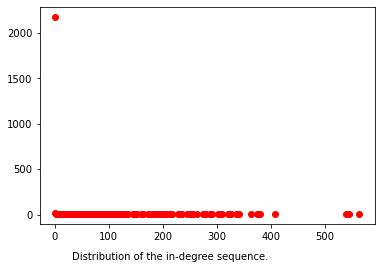

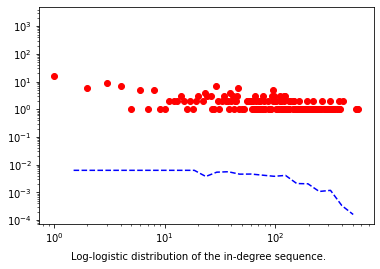

In [133]:
# Plotting in-degree distribution
# !pip install powerlaw
import powerlaw
import collections
import matplotlib.pyplot as plt
import numpy as np

# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
in_degrees, in_counts = zip(*degree_count.items())

# Calculate the exponent of the degree distribution
fit = powerlaw.Fit(in_degrees, xmin=-500, xmax=20000)

fig, norm_ax = plt.subplots()
norm_ax.plot(in_degrees, in_counts, 'ro')
fig.text(.2, .002, "Fig 1: Distribution of the in-degree sequence.")
plt.show()

fig, loglog_ax = plt.subplots()
loglog_ax.loglog(in_degrees, in_counts, 'ro')
fit.plot_pdf(color= 'b', linestyle='--', ax=loglog_ax)
fig.text(.2, .002, "Fig 2: Log-logistic distribution of the in-degree sequence.")
plt.show()

The majority of the nodes have a degree of 0, while the few most-popular nodes have a very highe degree, as can be seen Fig 1. This resembles a scale free distribution, therefore, for the sake of better visualization, we plotted it as a loglog graph, along with the exponent of the degree distribution calculated using the powerlaw package, see Fig 2. These visualizations provide a useful insight into the network: We can see that a lot of characters refer to a very popular character -- such as Spider-Man -- while no other nodes refer to them.

Values less than or equal to 0 in data. Throwing out 0 or negative values
/Users/kar/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


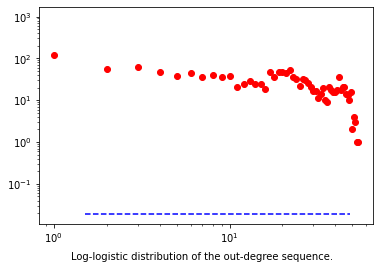

In [120]:
# Plotting out-degree distribution

degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
out_degrees, out_counts = zip(*degree_count.items())

# Calculate the exponent of the degree distribution
fit = powerlaw.Fit(out_degrees, xmin=-1000, xmax=1000)

fig, main_ax = plt.subplots()
main_ax.loglog(out_degrees, out_counts, 'ro')
fig.text(.2, .002, "Log-logistic distribution of the out-degree sequence.")
plt.show()

Reflecting on the slope...

In [82]:
# Plotting the network using ForceAtlas algorithm

# First, let's extract the giant connected component: it will be more interesting to visualize

subgraphs = [G.subgraph(c) for c in nx.weakly_connected_components(G)]
GCC = subgraphs[0]
for subgraph in subgraphs[1:]:
    if subgraph.number_of_nodes() > GCC.number_of_nodes():
        GCC = subgraph
        
GCC_undirected = GCC.to_undirected()

# Universe attribute
attributes_dict = {}
for i in marvel_name_nodeLinks.keys():
    attributes_dict[i] = "marvel"

for i in DC_name_nodeLinks.keys():
    attributes_dict[i] = "dc"

nx.set_node_attributes(GCC_undirected, attributes_dict, name="universe")

In [90]:
# !pip install fa2
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:33<00:00, 60.31it/s]

BarnesHut Approximation  took  13.00  seconds
Repulsion forces  took  18.14  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.48  seconds
AdjustSpeedAndApplyForces step  took  0.64  seconds


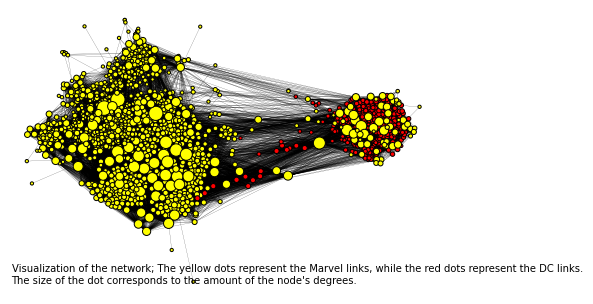

In [108]:
import collections

node_colors = []

for node in list(GCC_undirected.nodes()):
    if node in DC_name_nodeLinks:
        node_color = "#FF0000"
    else:
        node_color = "#FFFF00"
    node_colors.append(node_color)

degree_sequence = [d for n, d in GCC_undirected.degree()]
degree_count = collections.Counter(degree_sequence)

offset = 10
scale = 200
degree_range = float(max(degree_sequence) - min(degree_sequence))
node_sizes = [offset + scale * degree / degree_range for degree in degree_sequence]

fig = plt.figure()
nx.draw(GCC_undirected, pos=positions, node_size=node_sizes, node_color=node_colors, width=0.15, edgecolors="#000000", linewidths=1)
caption = """
Visualization of the network; The yellow dots represent the Marvel links, while the red dots represent the DC links. 
The size of the dot corresponds to the amount of the node's degrees.
"""
fig.text(0.01, 0.0001, caption)
plt.show()

### Communities

### Sentiment

>First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

In [60]:
# IMPORTS
import nltk, pprint
from nltk.corpus import stopwords

In order to calculate the sentiment for all character pages we first give a measurement of hapiness of a list of tokens. This list of tokens are given to us by the file _LabMT.txt_ in this repository.

In [63]:
# Extract a list of words with their hapiness score
labmt = np.loadtxt('LabMT.txt', dtype=str, delimiter='\t')
header = labmt[0, :]
word_list = labmt[1:, :]

# Function that extracts the sentiment of a list of tokens
def getSentiment(tokens):
    results = []
    for token in tokens:
        index, _ = np.where(token == word_list)
        if len(index) > 0:
            word_sentiment = word_list[index[0], 2]
            results.append(float(word_sentiment))
        else:
            results.append(0.0)
    return results

In [70]:
# Function to clean text: remove punctuation, lower case, tokenize, lemmatize, remove stopwords and remove wikilinks.

def processText(text):
    
    # Remove punctuation
    no_punct = re.sub(r'[^\w\s]', ' ', text)
    no_punct = re.sub(r'\n', ' ', no_punct)
        
    # Lower case
    no_punct = no_punct.lower()
    
    # Tokenizer
    text = nltk.word_tokenize(no_punct)
        
    # Lemmatizer
    wnl = nltk.WordNetLemmatizer()
    tokens = [wnl.lemmatize(t) for t in text]
    
    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [w for w in tokens if w.lower() not in stopwords]
        
    # Remove wiki syntax
    wikiwords = ["ref", "wa", "title", "cite", "web","x", "url"]
    tokens = [w for w in tokens if w.lower() not in wikiwords]
    
    return tokens

In [106]:
# Create the dictionary where the keys are the characters and values are the list of tokens of their wiki page

tokens_dict = {}

# Marvel
for name in marvel_wiki_responses_pages.keys():
    try: 
        # Extract the content of the wiki page
        wiki_page = marvel_wiki_responses_pages[name]
        key = list(wiki_page['query']['pages'].keys())[0]
        content = wiki_page['query']['pages'][key]['revisions'][0]['*']
    
        # Process the text
        tokens_dict[name] = processText(content)
    
    except:
        print(name)

Master_Man_(Marvel_Comics)|l1=Master_Man
Master_of_the_World_(comics)|l1=Master_of_the_World
Vidar_(Marvel_Comics)


In [108]:
# DC

for name in dc_wiki_responses_pages.keys():
    try: 
        # Extract the content of the wiki page
        wiki_page = dc_wiki_responses_pages[name]
        key = list(wiki_page['query']['pages'].keys())[0]
        content = wiki_page['query']['pages'][key]['revisions'][0]['*']
    
        # Process the text
        tokens_dict[name] = processText(content)
    
    except:
        print(name)

Viperie_(Action_Comics_338)
Vizacacha
Volthoom
Hans_Vroom_(Action_Comics_93)
Tri_Vul_(The_Brave_and_the_Bold,_Vol._1,_155)
X'_Hal
X-2-Y_(Action_Comics_344)
X-5_Super_Agent_(Quality_Comics)
X_of_the_Underground
Xardo_(Action_Comics_325)
Xasnu_(Action_Comics_278)
X-Bomb_Betty
Xenofobe
Xeo
Xera_(comics)
Xero_(comics)
Xiang-Fa_(Green_Lantern,_Vol._3,_19)
Xov_(Action_Comics_242)


In [109]:
# Function to calculate the sentiment of a document based on the list of tokens

def getSentimentDocument(tokens):
    df1 = pd.DataFrame({"token":list(set(tokens))})
    df1["freq"] = df1["token"].apply(lambda x: nltk.FreqDist(tokens)[x])
    df1["score"] = df1["token"].apply(lambda x: getSentiment([x])[0])
    df1["score"] = df1["score"] * df1.freq
    sentiment_score = df1["score"].sum() / df1[df1.score != 0]["freq"].sum()
    return sentiment_score

In [110]:
# Create the dictionary where the keys are characters and values are the sentiment of the content of the wiki page

sentiments_dict = {}

for name in tokens_dict.keys():

    tokens = tokens_dict[name]
    sentiments_dict[name] = getSentimentDocument(tokens)

/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/1242693483.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sentiment_score = df1["score"].sum() / df1[df1.score != 0]["freq"].sum()
/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/1242693483.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sentiment_score = df1["score"].sum() / df1[df1.score != 0]["freq"].sum()
/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/1242693483.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sentiment_score = df1["score"].sum() / df1[df1.score != 0]["freq"].sum()
/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/1242693483.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sentiment_score = df1["score"].sum() / df1[df1.score != 0]["freq"].sum()
/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/1242693483.py:8: RuntimeWarning: invalid value encountered in double_sca

In [112]:
# Adding the attribute 'sentiment' to the nodes of the network
nx.set_node_attributes(G, sentiments_dict, name='sentiment')

The mean value of the sentiment distribution is:  5.742967365028843
The percentile 10th and 90th are:  [5.466      5.98381071]


Text(0.5, 1.0, 'Sentiment of character pages distribution')

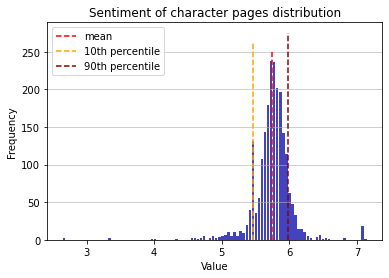

In [127]:
# Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment.
sentiments_distribution = list(sentiments_dict.values())
sentiments_distribution = [item for item in sentiments_distribution if not(math.isnan(item)) == True]

print("The mean value of the sentiment distribution is: ", np.mean(sentiments_distribution))
print("The percentile 10th and 90th are: ", np.percentile(sentiments_distribution, [10,90]))


# Histogram
fig, ax = plt.subplots()
plt.hist(sentiments_distribution, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(sentiments_distribution), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(sentiments_distribution, 10), ax.get_ylim()[0],ax.get_ylim()[1], label = "10th percentile", ls = "--", color = "orange")
ax.vlines(np.percentile(sentiments_distribution, 90), ax.get_ylim()[0],ax.get_ylim()[1], label = "90th percentile", ls = "--", color = "darkred")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment of character pages distribution')

>Now grab the good/bad character names (from this file, see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.



The mean value of the sentiment distribution for good characters is:  5.829954729851756
The percentile 10th and 90th are:  [5.65050296 5.96400134]


Text(0.5, 1.0, 'Sentiment of good character pages distribution')

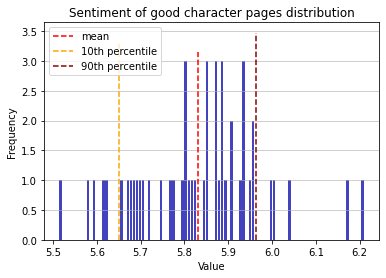

In [129]:
# Statistics for GOOD characters

wiki_meta_data = pd.read_csv('wiki_meta_data.csv', sep=',', header=None)
wiki_meta_data = wiki_meta_data.to_numpy()

# Get good character names
good_characters_indices = np.where(wiki_meta_data[:, 6] == '1')
good_characters = wiki_meta_data[good_characters_indices, 1][0] ########## WE STILL NEED TO FIX THIS, NAMES OF NODES IN THE NETWORK!!
good_characters_info = {}

for character in good_characters:
    character_modified = character.split("(")[0]
    character_modified = character.replace("_", ".")

    corresponding_node = None
    for node in G.nodes():
        if node == character_modified:
            corresponding_node = node
            break

    if corresponding_node == None:
        continue

    sentiment = G.nodes[corresponding_node]['sentiment'] # cuidado, hacer tambien dc!!
    good_characters_info[character] = sentiment
    

# Statistics 
good_characters_sentiment = list(good_characters_info.values())

print("The mean value of the sentiment distribution for good characters is: ", np.mean(good_characters_sentiment))
print("The percentile 10th and 90th are: ", np.percentile(good_characters_sentiment, [10,90]))


# Histogram
fig, ax = plt.subplots()
plt.hist(good_characters_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(good_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(good_characters_sentiment, 10), ax.get_ylim()[0],ax.get_ylim()[1], label = "10th percentile", ls = "--", color = "orange")
ax.vlines(np.percentile(good_characters_sentiment, 90), ax.get_ylim()[0],ax.get_ylim()[1], label = "90th percentile", ls = "--", color = "darkred")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment distribution for good character pages')

The mean value of the sentiment distribution for bad characters is:  5.746243697782249
The percentile 10th and 90th are:  [5.61387123 5.89032736]


Text(0.5, 1.0, 'Sentiment of bad character pages distribution')

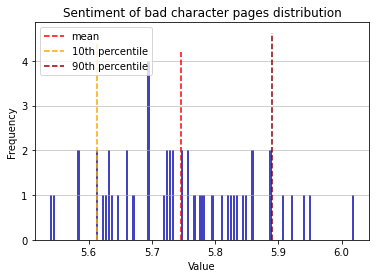

In [134]:
# Statistics for BAD characters

# Get bad character names
bad_characters_indices = np.where(wiki_meta_data[:, 7] == '1')
bad_characters = wiki_meta_data[bad_characters_indices, 1][0] ##### FIX THIS 
bad_characters_info = {}

for character in bad_characters:
    character_modified = character.split("(")[0]
    character_modified = character.replace("_", ".")

    corresponding_node = None
    for node in G.nodes():
        if node == character_modified:
            corresponding_node = node
            break

    if corresponding_node == None:
        continue

    sentiment = G.nodes[corresponding_node]['sentiment']
    bad_characters_info[character] = sentiment
    

# Statistics
bad_characters_sentiment = list(bad_characters_info.values())

print("The mean value of the sentiment distribution for bad characters is: ", np.mean(bad_characters_sentiment))
print("The percentile 10th and 90th are: ", np.percentile(bad_characters_sentiment, [10,90]))

# Histogram
fig, ax = plt.subplots()
plt.hist(bad_characters_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(bad_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(bad_characters_sentiment, 10), ax.get_ylim()[0],ax.get_ylim()[1], label = "10th percentile", ls = "--", color = "orange")
ax.vlines(np.percentile(bad_characters_sentiment, 90), ax.get_ylim()[0],ax.get_ylim()[1], label = "90th percentile", ls = "--", color = "darkred")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment of bad character pages distribution')

>Finally use the label permutation test (see Week 5) to investigate the two hypotheses below:
>- H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
>- H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

>Write a short paragraph reflecting on your findings.

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/308198418.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  R = random.sample(G.nodes(), size)


 342
Iteration 343
Iteration 344
Iteration 345
Iteration 346
Iteration 347
Iteration 348
Iteration 349
Iteration 350
Iteration 351
Iteration 352
Iteration 353
Iteration 354
Iteration 355
Iteration 356
Iteration 357
Iteration 358
Iteration 359
Iteration 360
Iteration 361
Iteration 362
Iteration 363
Iteration 364
Iteration 365
Iteration 366
Iteration 367
Iteration 368
Iteration 369
Iteration 370
Iteration 371
Iteration 372
Iteration 373
Iteration 374
Iteration 375
Iteration 376
Iteration 377
Iteration 378
Iteration 379
Iteration 380
Iteration 381
Iteration 382
Iteration 383
Iteration 384
Iteration 385
Iteration 386
Iteration 387
Iteration 388
Iteration 389
Iteration 390
Iteration 391
Iteration 392
Iteration 393
Iteration 394
Iteration 395
Iteration 396
Iteration 397
Iteration 398
Iteration 399
Iteration 400
Iteration 401
Iteration 402
Iteration 403
Iteration 404
Iteration 405
Iteration 406
Iteration 407
Iteration 408
Iteration 409
Iteration 410
Iteration 411
Iteration 412
Iteration 413
I

Iteration 973
Iteration 974
Iteration 975
Iteration 976
Iteration 977
Iteration 978
Iteration 979
Iteration 980
Iteration 981
Iteration 982
Iteration 983
Iteration 984
Iteration 985
Iteration 986
Iteration 987
Iteration 988
Iteration 989
Iteration 990
Iteration 991
Iteration 992
Iteration 993
Iteration 994
Iteration 995
Iteration 996
Iteration 997
Iteration 998
Iteration 999
Iteration 1000
Iteration 1001
Iteration 1002
Iteration 1003
Iteration 1004
Iteration 1005
Iteration 1006
Iteration 1007
Iteration 1008
Iteration 1009
Iteration 1010
Iteration 1011
Iteration 1012
Iteration 1013
Iteration 1014
Iteration 1015
Iteration 1016
Iteration 1017
Iteration 1018
Iteration 1019
Iteration 1020
Iteration 1021
Iteration 1022
Iteration 1023
Iteration 1024
Iteration 1025
Iteration 1026
Iteration 1027
Iteration 1028
Iteration 1029
Iteration 1030
Iteration 1031
Iteration 1032
Iteration 1033
Iteration 1034
Iteration 1035
Iteration 1036
Iteration 1037
Iteration 1038
Iteration 1039
Iteration 1040
Iterati

Iteration 1585
Iteration 1586
Iteration 1587
Iteration 1588
Iteration 1589
Iteration 1590
Iteration 1591
Iteration 1592
Iteration 1593
Iteration 1594
Iteration 1595
Iteration 1596
Iteration 1597
Iteration 1598
Iteration 1599
Iteration 1600
Iteration 1601
Iteration 1602
Iteration 1603
Iteration 1604
Iteration 1605
Iteration 1606
Iteration 1607
Iteration 1608
Iteration 1609
Iteration 1610
Iteration 1611
Iteration 1612
Iteration 1613
Iteration 1614
Iteration 1615
Iteration 1616
Iteration 1617
Iteration 1618
Iteration 1619
Iteration 1620
Iteration 1621
Iteration 1622
Iteration 1623
Iteration 1624
Iteration 1625
Iteration 1626
Iteration 1627
Iteration 1628
Iteration 1629
Iteration 1630
Iteration 1631
Iteration 1632
Iteration 1633
Iteration 1634
Iteration 1635
Iteration 1636
Iteration 1637
Iteration 1638
Iteration 1639
Iteration 1640
Iteration 1641
Iteration 1642
Iteration 1643
Iteration 1644
Iteration 1645
Iteration 1646
Iteration 1647
Iteration 1648
Iteration 1649
Iteration 1650
Iteration 

Iteration 2222
Iteration 2223
Iteration 2224
Iteration 2225
Iteration 2226
Iteration 2227
Iteration 2228
Iteration 2229
Iteration 2230
Iteration 2231
Iteration 2232
Iteration 2233
Iteration 2234
Iteration 2235
Iteration 2236
Iteration 2237
Iteration 2238
Iteration 2239
Iteration 2240
Iteration 2241
Iteration 2242
Iteration 2243
Iteration 2244
Iteration 2245
Iteration 2246
Iteration 2247
Iteration 2248
Iteration 2249
Iteration 2250
Iteration 2251
Iteration 2252
Iteration 2253
Iteration 2254
Iteration 2255
Iteration 2256
Iteration 2257
Iteration 2258
Iteration 2259
Iteration 2260
Iteration 2261
Iteration 2262
Iteration 2263
Iteration 2264
Iteration 2265
Iteration 2266
Iteration 2267
Iteration 2268
Iteration 2269
Iteration 2270
Iteration 2271
Iteration 2272
Iteration 2273
Iteration 2274
Iteration 2275
Iteration 2276
Iteration 2277
Iteration 2278
Iteration 2279
Iteration 2280
Iteration 2281
Iteration 2282
Iteration 2283
Iteration 2284
Iteration 2285
Iteration 2286
Iteration 2287
Iteration 

Iteration 2849
Iteration 2850
Iteration 2851
Iteration 2852
Iteration 2853
Iteration 2854
Iteration 2855
Iteration 2856
Iteration 2857
Iteration 2858
Iteration 2859
Iteration 2860
Iteration 2861
Iteration 2862
Iteration 2863
Iteration 2864
Iteration 2865
Iteration 2866
Iteration 2867
Iteration 2868
Iteration 2869
Iteration 2870
Iteration 2871
Iteration 2872
Iteration 2873
Iteration 2874
Iteration 2875
Iteration 2876
Iteration 2877
Iteration 2878
Iteration 2879
Iteration 2880
Iteration 2881
Iteration 2882
Iteration 2883
Iteration 2884
Iteration 2885
Iteration 2886
Iteration 2887
Iteration 2888
Iteration 2889
Iteration 2890
Iteration 2891
Iteration 2892
Iteration 2893
Iteration 2894
Iteration 2895
Iteration 2896
Iteration 2897
Iteration 2898
Iteration 2899
Iteration 2900
Iteration 2901
Iteration 2902
Iteration 2903
Iteration 2904
Iteration 2905
Iteration 2906
Iteration 2907
Iteration 2908
Iteration 2909
Iteration 2910
Iteration 2911
Iteration 2912
Iteration 2913
Iteration 2914
Iteration 

Iteration 3471
Iteration 3472
Iteration 3473
Iteration 3474
Iteration 3475
Iteration 3476
Iteration 3477
Iteration 3478
Iteration 3479
Iteration 3480
Iteration 3481
Iteration 3482
Iteration 3483
Iteration 3484
Iteration 3485
Iteration 3486
Iteration 3487
Iteration 3488
Iteration 3489
Iteration 3490
Iteration 3491
Iteration 3492
Iteration 3493
Iteration 3494
Iteration 3495
Iteration 3496
Iteration 3497
Iteration 3498
Iteration 3499
Iteration 3500
Iteration 3501
Iteration 3502
Iteration 3503
Iteration 3504
Iteration 3505
Iteration 3506
Iteration 3507
Iteration 3508
Iteration 3509
Iteration 3510
Iteration 3511
Iteration 3512
Iteration 3513
Iteration 3514
Iteration 3515
Iteration 3516
Iteration 3517
Iteration 3518
Iteration 3519
Iteration 3520
Iteration 3521
Iteration 3522
Iteration 3523
Iteration 3524
Iteration 3525
Iteration 3526
Iteration 3527
Iteration 3528
Iteration 3529
Iteration 3530
Iteration 3531
Iteration 3532
Iteration 3533
Iteration 3534
Iteration 3535
Iteration 3536
Iteration 

Iteration 4048
Iteration 4049
Iteration 4050
Iteration 4051
Iteration 4052
Iteration 4053
Iteration 4054
Iteration 4055
Iteration 4056
Iteration 4057
Iteration 4058
Iteration 4059
Iteration 4060
Iteration 4061
Iteration 4062
Iteration 4063
Iteration 4064
Iteration 4065
Iteration 4066
Iteration 4067
Iteration 4068
Iteration 4069
Iteration 4070
Iteration 4071
Iteration 4072
Iteration 4073
Iteration 4074
Iteration 4075
Iteration 4076
Iteration 4077
Iteration 4078
Iteration 4079
Iteration 4080
Iteration 4081
Iteration 4082
Iteration 4083
Iteration 4084
Iteration 4085
Iteration 4086
Iteration 4087
Iteration 4088
Iteration 4089
Iteration 4090
Iteration 4091
Iteration 4092
Iteration 4093
Iteration 4094
Iteration 4095
Iteration 4096
Iteration 4097
Iteration 4098
Iteration 4099
Iteration 4100
Iteration 4101
Iteration 4102
Iteration 4103
Iteration 4104
Iteration 4105
Iteration 4106
Iteration 4107
Iteration 4108
Iteration 4109
Iteration 4110
Iteration 4111
Iteration 4112
Iteration 4113
Iteration 

Iteration 4692
Iteration 4693
Iteration 4694
Iteration 4695
Iteration 4696
Iteration 4697
Iteration 4698
Iteration 4699
Iteration 4700
Iteration 4701
Iteration 4702
Iteration 4703
Iteration 4704
Iteration 4705
Iteration 4706
Iteration 4707
Iteration 4708
Iteration 4709
Iteration 4710
Iteration 4711
Iteration 4712
Iteration 4713
Iteration 4714
Iteration 4715
Iteration 4716
Iteration 4717
Iteration 4718
Iteration 4719
Iteration 4720
Iteration 4721
Iteration 4722
Iteration 4723
Iteration 4724
Iteration 4725
Iteration 4726
Iteration 4727
Iteration 4728
Iteration 4729
Iteration 4730
Iteration 4731
Iteration 4732
Iteration 4733
Iteration 4734
Iteration 4735
Iteration 4736
Iteration 4737
Iteration 4738
Iteration 4739
Iteration 4740
Iteration 4741
Iteration 4742
Iteration 4743
Iteration 4744
Iteration 4745
Iteration 4746
Iteration 4747
Iteration 4748
Iteration 4749
Iteration 4750
Iteration 4751
Iteration 4752
Iteration 4753
Iteration 4754
Iteration 4755
Iteration 4756
Iteration 4757
Iteration 

/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6611: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/alejandranavarrocastillo/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6612: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

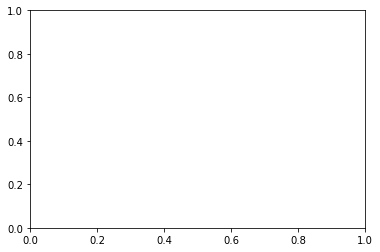

In [138]:
# Label permutation test to investigate H1

import random

size = len(good_characters)
average_sentiment = []

for iteration in range(5000):
    try: 
        # Select random graph of size of the sub graph of good characters
        R = random.sample(G.nodes(), size)
        sentiments = nx.get_node_attributes(G, "sentiment")
        sentiments_R = [sentiments[k] for k in R]
        average_sentiment.append(np.mean(sentiments_R))
        
    except:
        print('No sentiment')

        
# Histogram
fig, ax = plt.subplots()
plt.hist(average_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(good_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean", ls = "--", color = "red")
ax.vlines(np.percentile(average_sentiment, 97.5), ax.get_ylim()[0], ax.get_ylim()[1], label = "95th percentile", ls = "--", color = "grey")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sentiment of bad character pages distribution')

/var/folders/8z/056rl9m15xqdp64zymjctkm40000gn/T/ipykernel_5213/3988562785.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  R = random.sample(G.nodes(), size)


ValueError: autodetected range of [nan, nan] is not finite

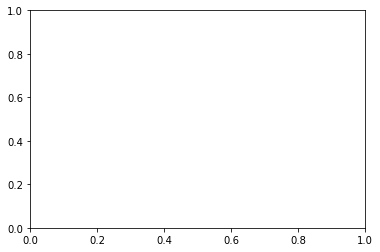

In [139]:
# Label permutation test to investigate H2

size = len(bad_characters)
average_sentiment = []

for iteration in range(5000):
    try: 
        # Select random graph of size of the sub graph of bad characters
        R = random.sample(G.nodes(), size)
        sentiments = nx.get_node_attributes(G, "sentiment")
        sentiments_R = [sentiments[k] for k in R]
        average_sentiment.append(np.mean(sentiments_R))
        
    except:
        print('No sentiment')


# Histogram
fig, ax = plt.subplots()
plt.hist(average_sentiment, bins=100, color='#0504aa', alpha = 0.75, range=None, weights=None, density=None, rwidth=0.80)

ax.vlines(np.mean(bad_characters_sentiment), ax.get_ylim()[0], ax.get_ylim()[1], label = "mean of the real bad character set", ls = "--", color = "red")
ax.vlines(np.percentile(average_sentiment, 5), ax.get_ylim()[0], ax.get_ylim()[1], label = "5th percentile", ls = "--", color = "grey")

plt.legend(loc = "upper left")
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Permutation distribution for means of bad characters sentiment')